In [1]:
devtools::install_github("ropensci/rnaturalearthhires")
invisible(lapply(c(
  "Cairo", "dplyr", "tidyr", "duckdb", "dbplyr", "ggplot2",
  "rnaturalearth", "rnaturalearthdata", "rnaturalearthhires",
  "sf", "gdalcubes", "terra", "tidyterra",
  "car", "corrplot", "stringr"
), library, character.only = TRUE))

gdalcubes_options(parallel = TRUE)

custom_palette <- c(
  "#0072B2",  "#D55E00", "#CC79A7", "#009E73", "#E69F00", "#56B4E9",
  "#F0E442", "#999999", "#000000"
)
options(
  repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300,
  repr.plot.antialias = "subpixel",
  contrasts = c("contr.sum", "contr.poly"),
  ggplot2.discrete.fill = custom_palette,
  ggplot2.discrete.colour = custom_palette
)
theme_set(
  theme_bw() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      legend.position = "top",
      legend.direction = "horizontal",
      legend.box = "vertical",
      panel.grid.major.x = element_blank(),
      panel.grid.minor = element_blank(),
      strip.background = element_blank(),
      axis.title = element_text(size = rel(1.1), face = "bold"),
      axis.text = element_text(size = rel(1.1), face = "bold"),
      strip.text = element_text(size = rel(1.1), face = "bold")
    )
)

Using GitHub PAT from the git credential store.

Skipping install of 'rnaturalearthhires' from a github remote, the SHA1 (e02c28da) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: DBI


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110


Warning message:
“package ‘rnaturalearthhires’ was built under R version 4.4.1”
Linking to GEOS 3.13.0, GDAL 3.9.3, PROJ 9.5.0; sf_use_s2() is TRUE

terra 1.7.83


Attaching package: ‘terra’


The following objects are masked from ‘package:gdalcubes’:

    animate, crop, size


The following object is masked from ‘package:tidyr

In [2]:
con <- dbConnect(
  duckdb(), dbdir = "../processing/amfungi_lsu.duckdb", read_only = FALSE
)
inner_join(
  tbl(con, "occurances") |> select(sample_id, taxon_id, abundance, total),
  tbl(con, "samples") |> select(id, longitude, latitude),
  by = join_by(sample_id == id)
) |>
  inner_join(
    tbl(con, "taxa") |> select(taxa_id, Species),
    by = join_by(taxon_id == taxa_id)
  ) |>
  compute(name = "locations")

# Source:   table<locations> [?? x 7]
# Database: DuckDB v1.0.0 [robert@Linux 6.8.0-48-generic:R 4.3.3//home/robert/Public/Github/biotic_niche_modeling/processing/amfungi_lsu.duckdb]
   sample_id taxon_id abundance  total longitude latitude Species               
   <chr>     <chr>        <int>  <int>     <dbl>    <dbl> <chr>                 
 1 7805      MT832194        12 221538    -116.      43.3 Rhizophagus irregular…
 2 7806      MT832194        41 951993    -116.      43.3 Rhizophagus irregular…
 3 7814      MT832194         2 139418    -116.      43.3 Rhizophagus irregular…
 4 8077      MT832194         5  30383    -116.      43.3 Rhizophagus irregular…
 5 7929      MT832194         2  54553    -116.      43.3 Rhizophagus irregular…
 6 8007      MT832194         1    765    -122.      48.8 Rhizophagus irregular…
 7 7806      MT832194         1 951993    -116.      43.3 Rhizophagus irregular…
 8 7807      MT832194         1  20890     -99.6     24.9 Rhizophagus irregular…
 9 7806

In [3]:
occ <- collect(tbl(con, "occurances"))
loc <- collect(tbl(con, "locations"))
tax <- collect(tbl(con, "taxa"))

nrow(occ)
nrow(loc)

[1] 398074

[1] 398074

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


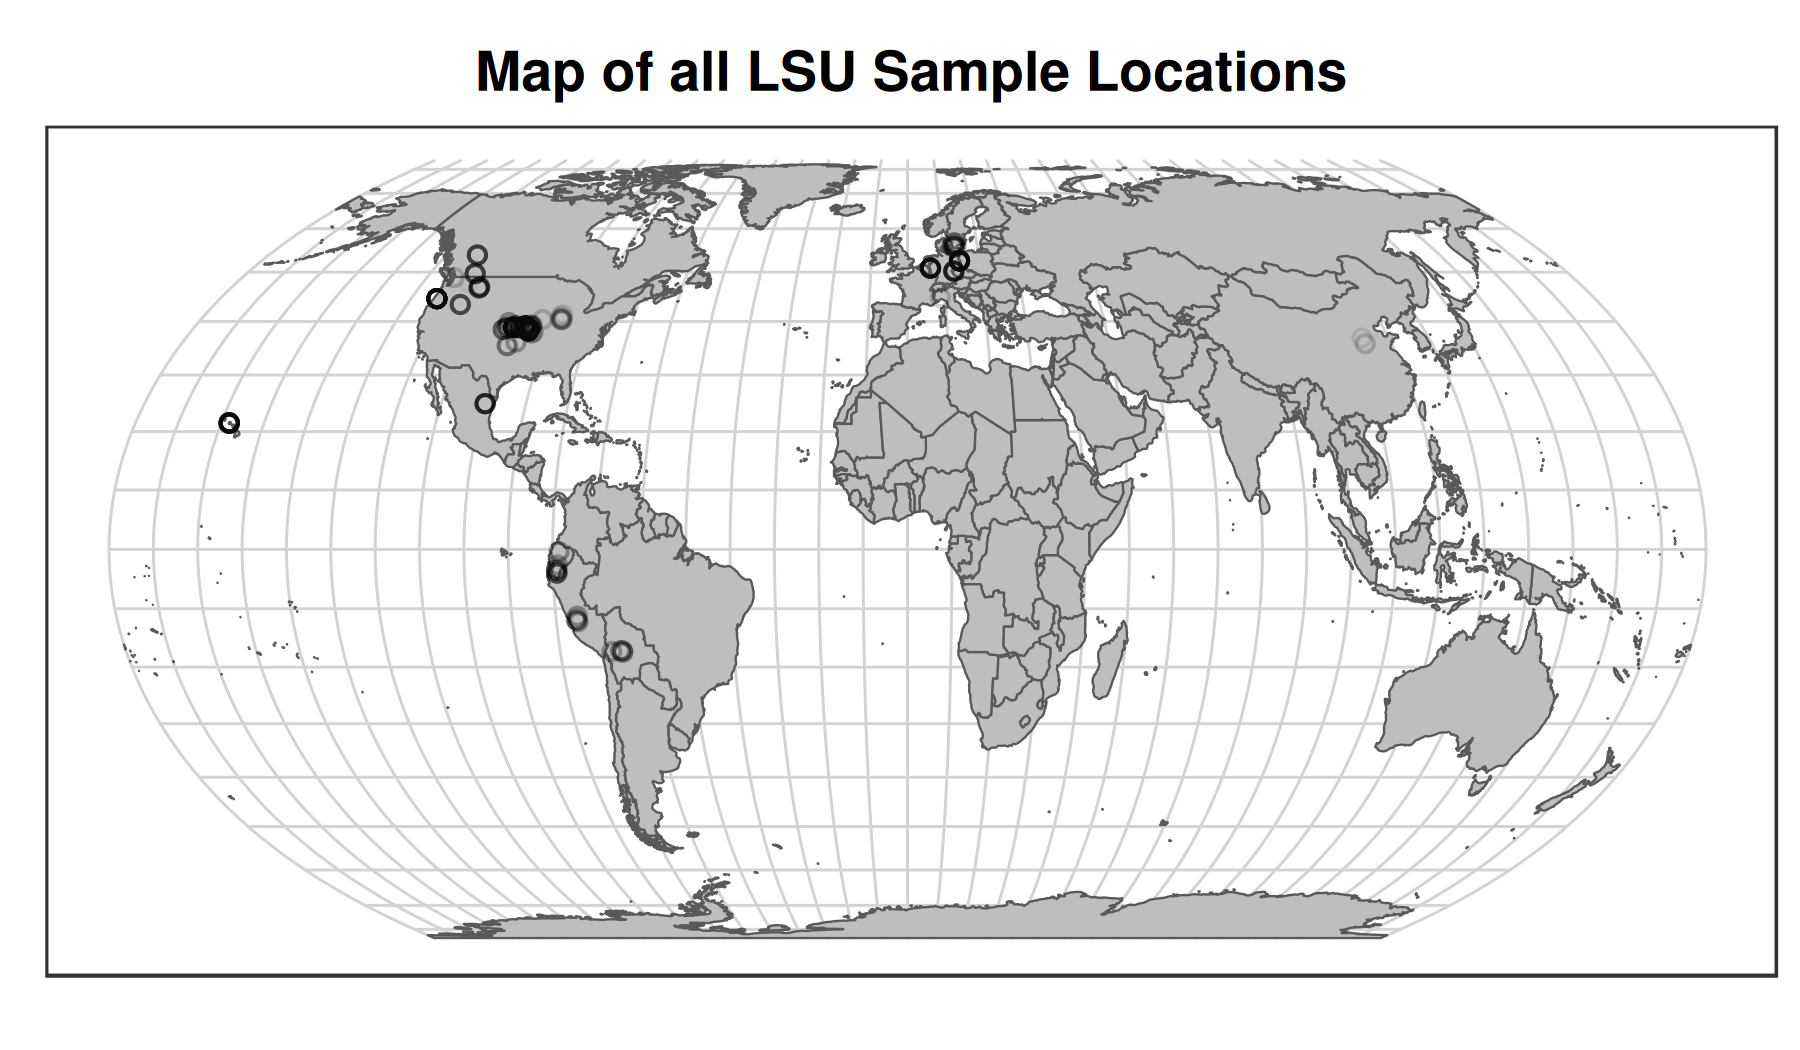

In [4]:
world <- ne_countries(scale = "medium", returnclass = "sf")
p <- ggplot(
  data = filter(tbl(con, "samples"), target_gene == "LSU")
) +
  geom_sf(
    data = world, fill = "grey", show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(crs = "WGS84 +proj=eqearth", default_crs = "EPSG:4326") +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Sample Locations"
  )
suppressWarnings(print(p))

In [5]:
count(tbl(con, "locations"), Species) |> collect() |> arrange(desc(n))


Species                    n     
1  Funneliformis mosseae      223099
2  Rhizophagus irregularis     64614
3  Funneliformis caledonius    48221
4  Claroideoglomus sp.         12782
5  Funneliformis sp.           12442
6  Sclerocystis sinuosa         9617
7  Claroideoglomus claroideum   4225
8  Microkamienskia perpusilla   2201
9  Glomeraceae_spp              2128
10 Glomus macrocarpum           2101
11 Septoglomus viscosum         1994
12 Rhizoglomus_sp               1834
13 Rhizophagus intraradices     1454
14 Microkamienskia divaricata   1430
15 Diversispora trimurales      1323
16 Halonatospora panshihalos    1093
17 Ambispora gerdemannii         891
18 Glomus sp.                    780
19 Otospora bareae               661
20 Rhizophagus fasciculatus      525
21 Dentiscutata heterogama       520
22 Claroideoglomus_sp            427
23 Innospora majewskii           408
24 Claroideoglomus candidum      308
25 Glomus_sp                     305
26 Acaulospora laevis            281
27 Septoglomus_sp                273
28 Oehlia diaphana               254
29 Septoglomus constrictum       246
30 Microdominikia litorea        194
31 Dominikia indica              183
32 Diversispora_sp               173
33 Acaulospora_sp                165
34 Claroideoglomus lamellosum    162
35 Claroideoglomus etunicatum    156
36 Rhizophagus proliferus        106
37 Funneliformis_sp               80
38 Paraglomus_sp                  72
39 Scutellospora_sp               45
40 Pacispora scintillans          37
41 Redeckera megalocarpa          33
42 Dominikia iranica              33
43 Gigaspora_sp                   32
44 Diversispora insculpta         31
45 Diversispora celata            31
46 Dominikia minuta               22
47 Ambispora_sp                   20
48 Acaulospora cavernata          18
49 Desertispora omaniana          12
50 Cetraspora_sp                  12
51 Archaeospora_sp                 9
52 Acaulospora spinosa             4
53 Entrophospora infrequens        4
54 Kamienskia bistrata             2
55 Gigaspora margarita             1

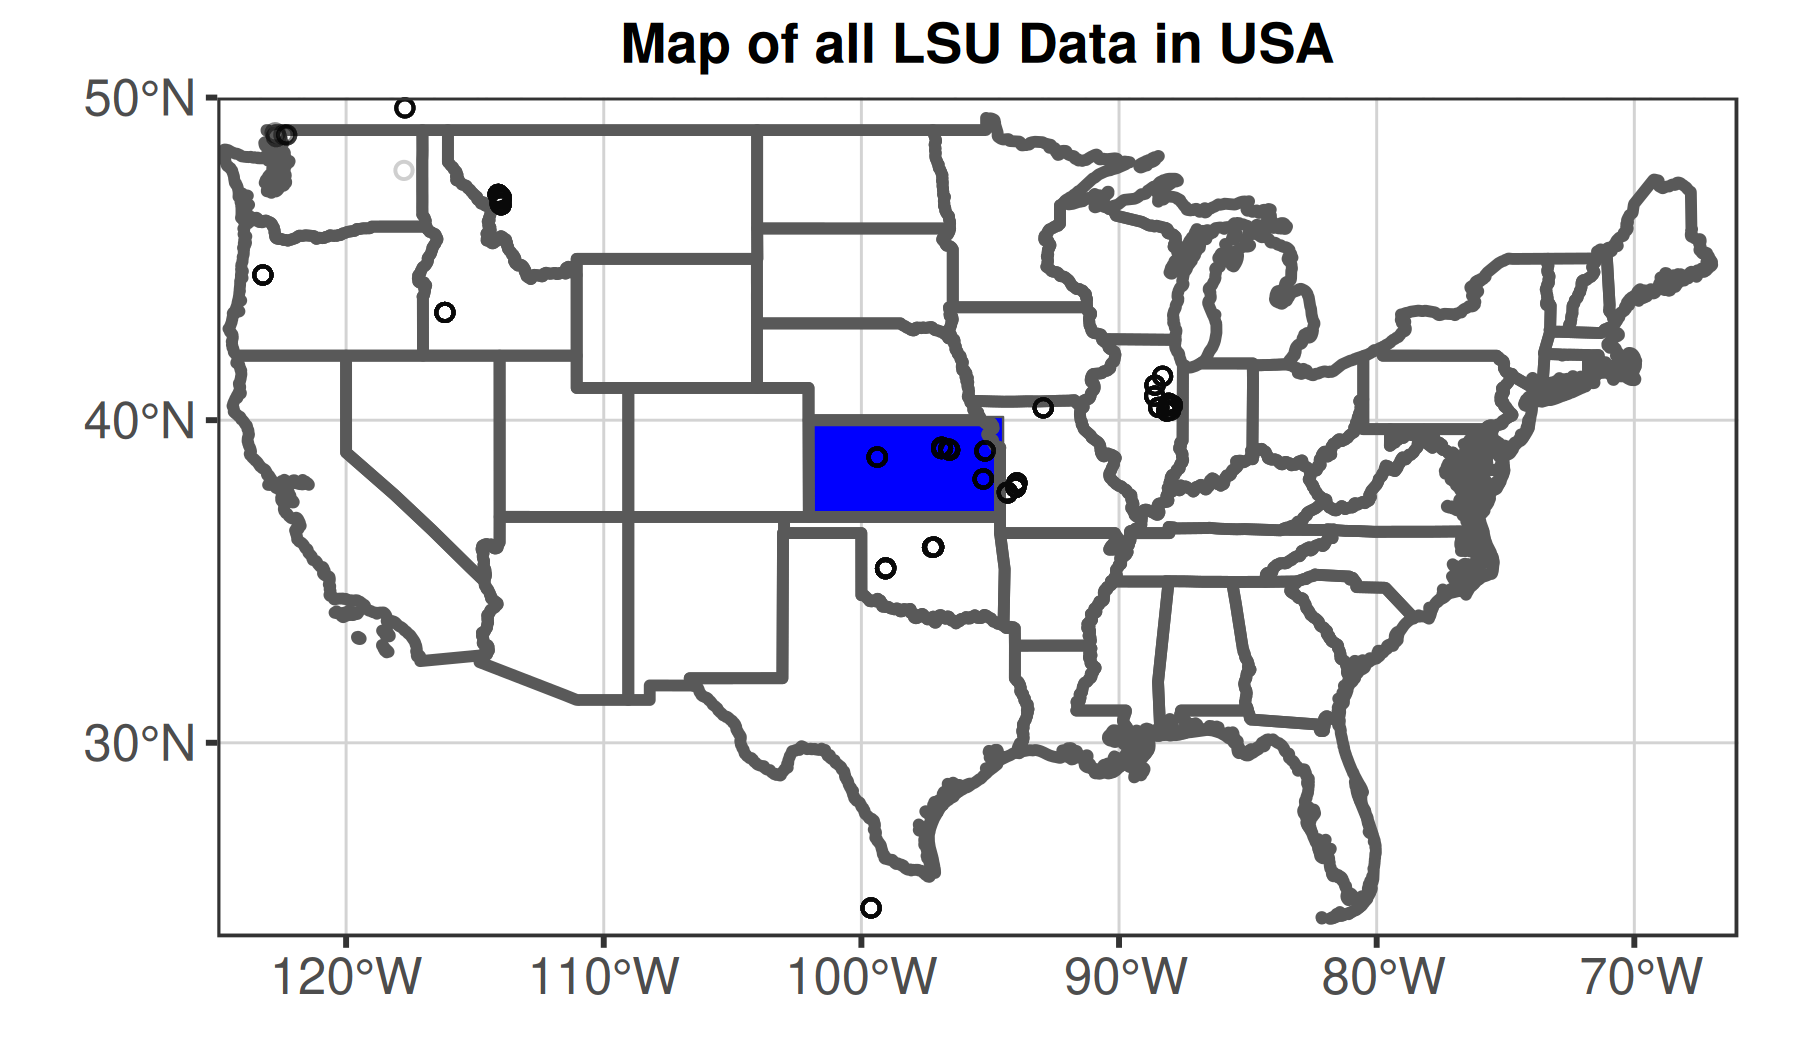

In [6]:
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
  # data = filter(tbl(con, "samples"), target_gene == "LSU")
  data = tbl(con, "locations")
) +
  geom_sf(
    data = st_as_sfc(
      st_bbox(c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1), crs = 4326)
    ), fill = "blue"
  ) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    # xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
    xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Data in USA"
  )
suppressWarnings(print(p))

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Species            n  
1  Glomeraceae_spp    951
2  Rhizoglomus_sp     756
3  Claroideoglomus_sp 179
4  Septoglomus_sp     133
5  Glomus_sp          120
6  Diversispora_sp     66
7  Acaulospora_sp      61
8  Funneliformis_sp    31
9  Paraglomus_sp       30
10 Gigaspora_sp        20
11 Ambispora_sp        10
12 Scutellospora_sp    10
13 Archaeospora_sp      3
14 Cetraspora_sp        3

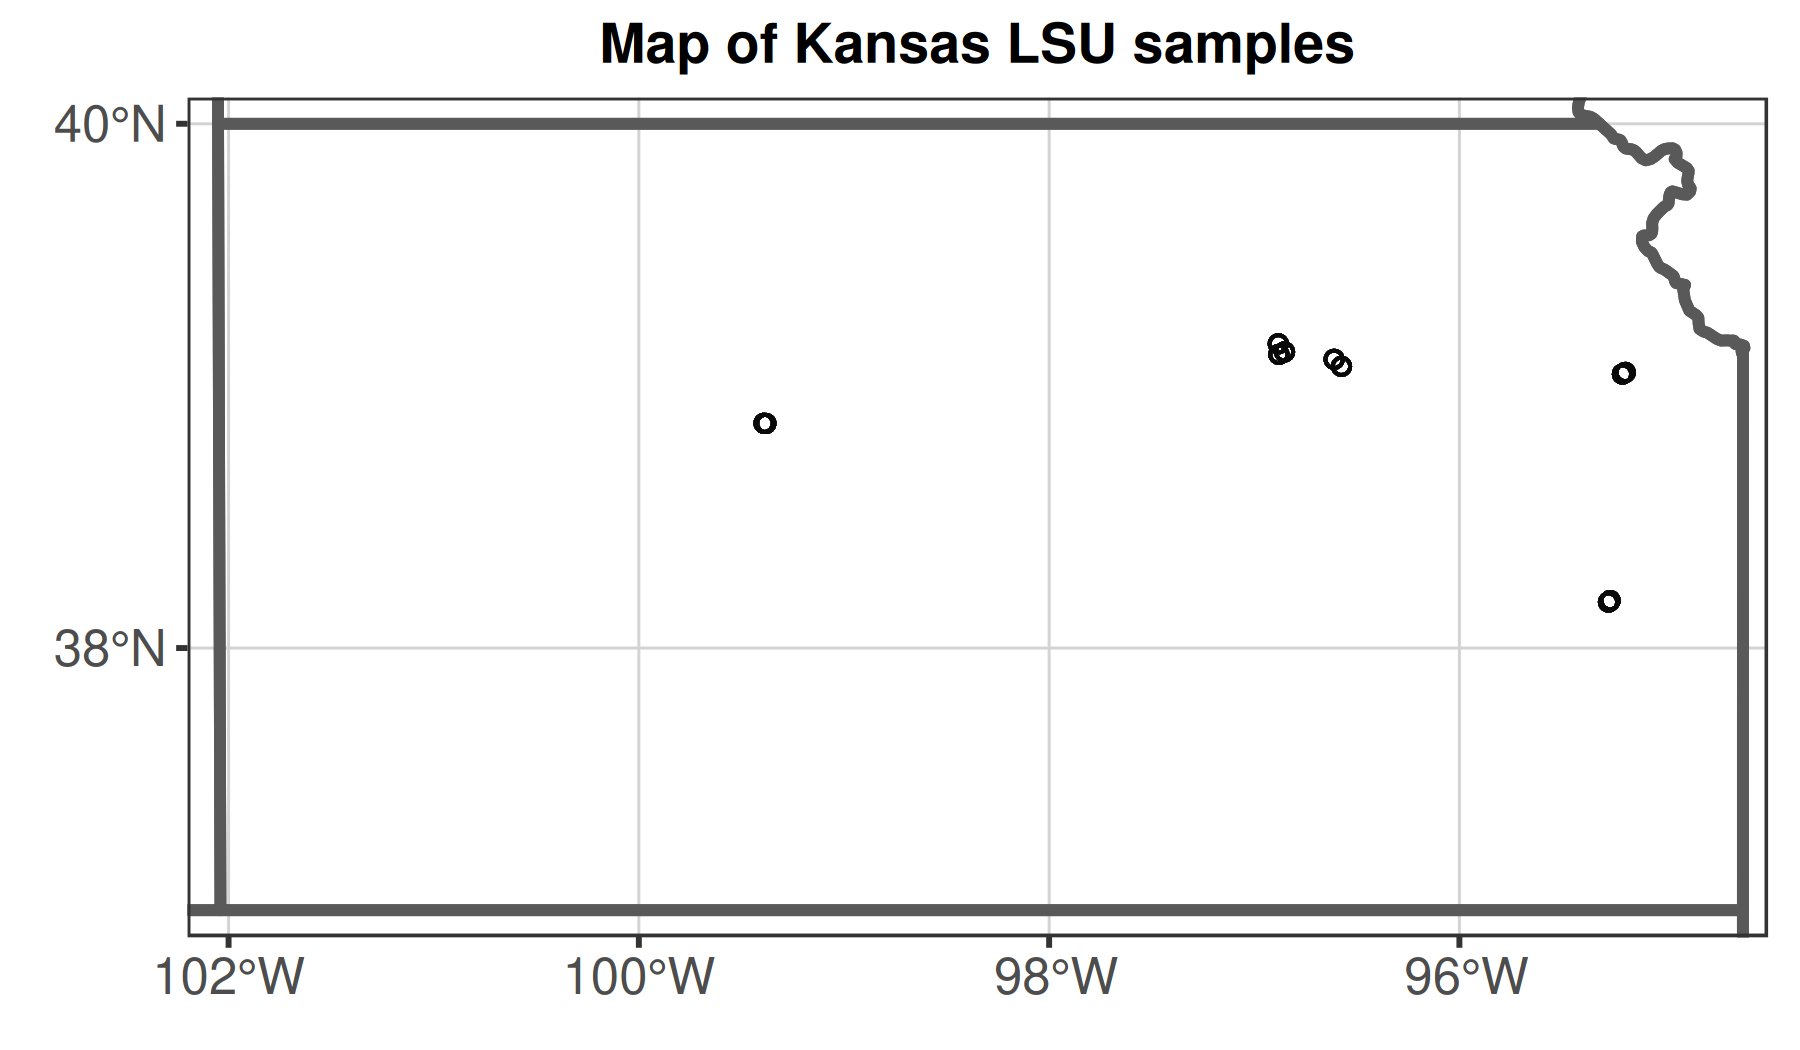

In [7]:
kansas_locations <- st_as_sf(
  collect(tbl(con, "locations")),
  coords = c('longitude', 'latitude'),
  crs = 4326
) |>
  st_crop(
    st_bbox(
      c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1),
      crs = 4326
    )
  )
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_sf(
    data = kansas_locations,
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 2)) +
  scale_y_continuous(breaks = seq(-90, 90, 2)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of Kansas LSU samples"
  )
suppressWarnings(print(p))
count(st_drop_geometry(kansas_locations), Species) |> arrange(desc(n))

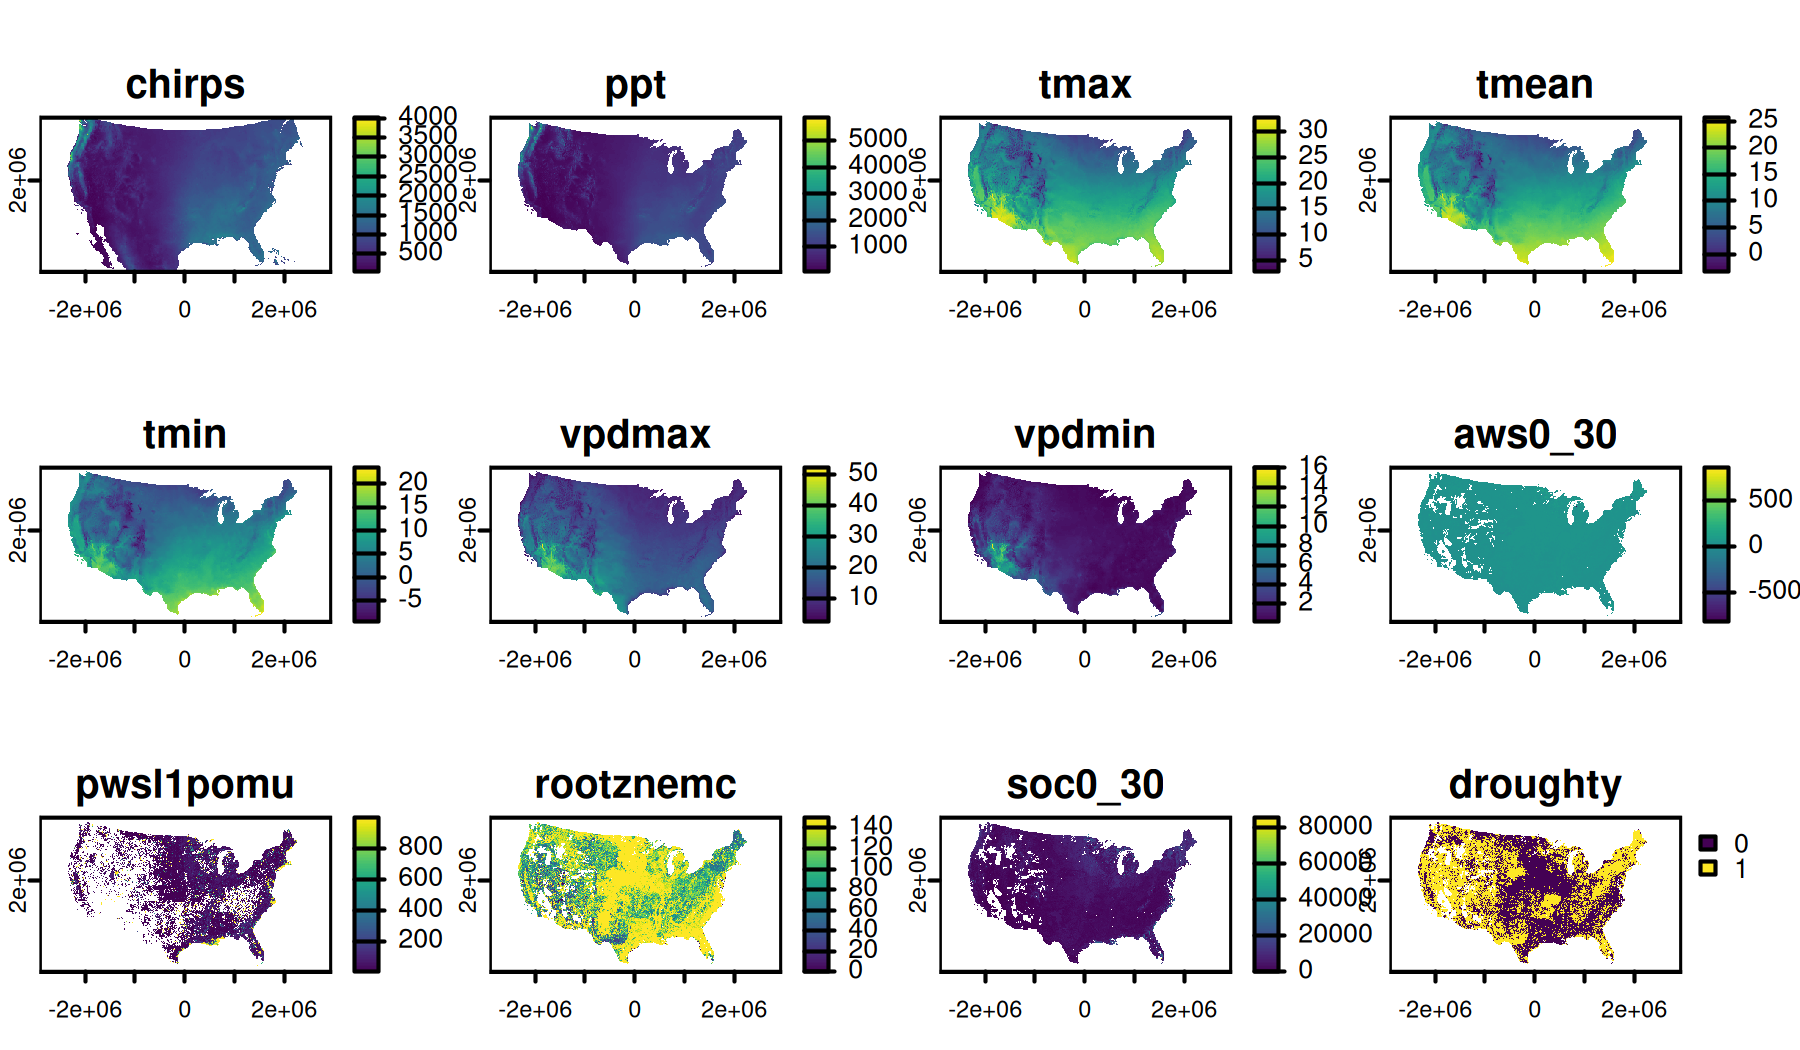

In [8]:
# gssurgo <- ncdf_cube("../processing/gis/gssurgo_1km.nc")
# gssurgo <- rast("../processing/gis/gssurgo_1km.nc")
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
plot(gis_dataset)

In [9]:
lsu_points <- kansas_locations
kansas_gis_dataset <- crop(
  gis_dataset,
  st_transform(st_bbox(
    c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1),
    crs = 4326
  ), 5070)
)
extraction <- extract(kansas_gis_dataset, lsu_points)
dataset <- st_drop_geometry(cbind(lsu_points, extraction[, -1]))
dataset$proportion <- dataset$abundance/dataset$total
colnames(dataset)

Warning message:
“[extract] transforming vector data to the CRS of the raster”


[1] "sample_id"  "taxon_id"   "abundance"  "total"      "Species"   
 [6] "chirps"     "ppt"        "tmax"       "tmean"      "tmin"      
[11] "vpdmax"     "vpdmin"     "aws0_30"    "pwsl1pomu"  "rootznemc" 
[16] "soc0_30"    "droughty"   "proportion"

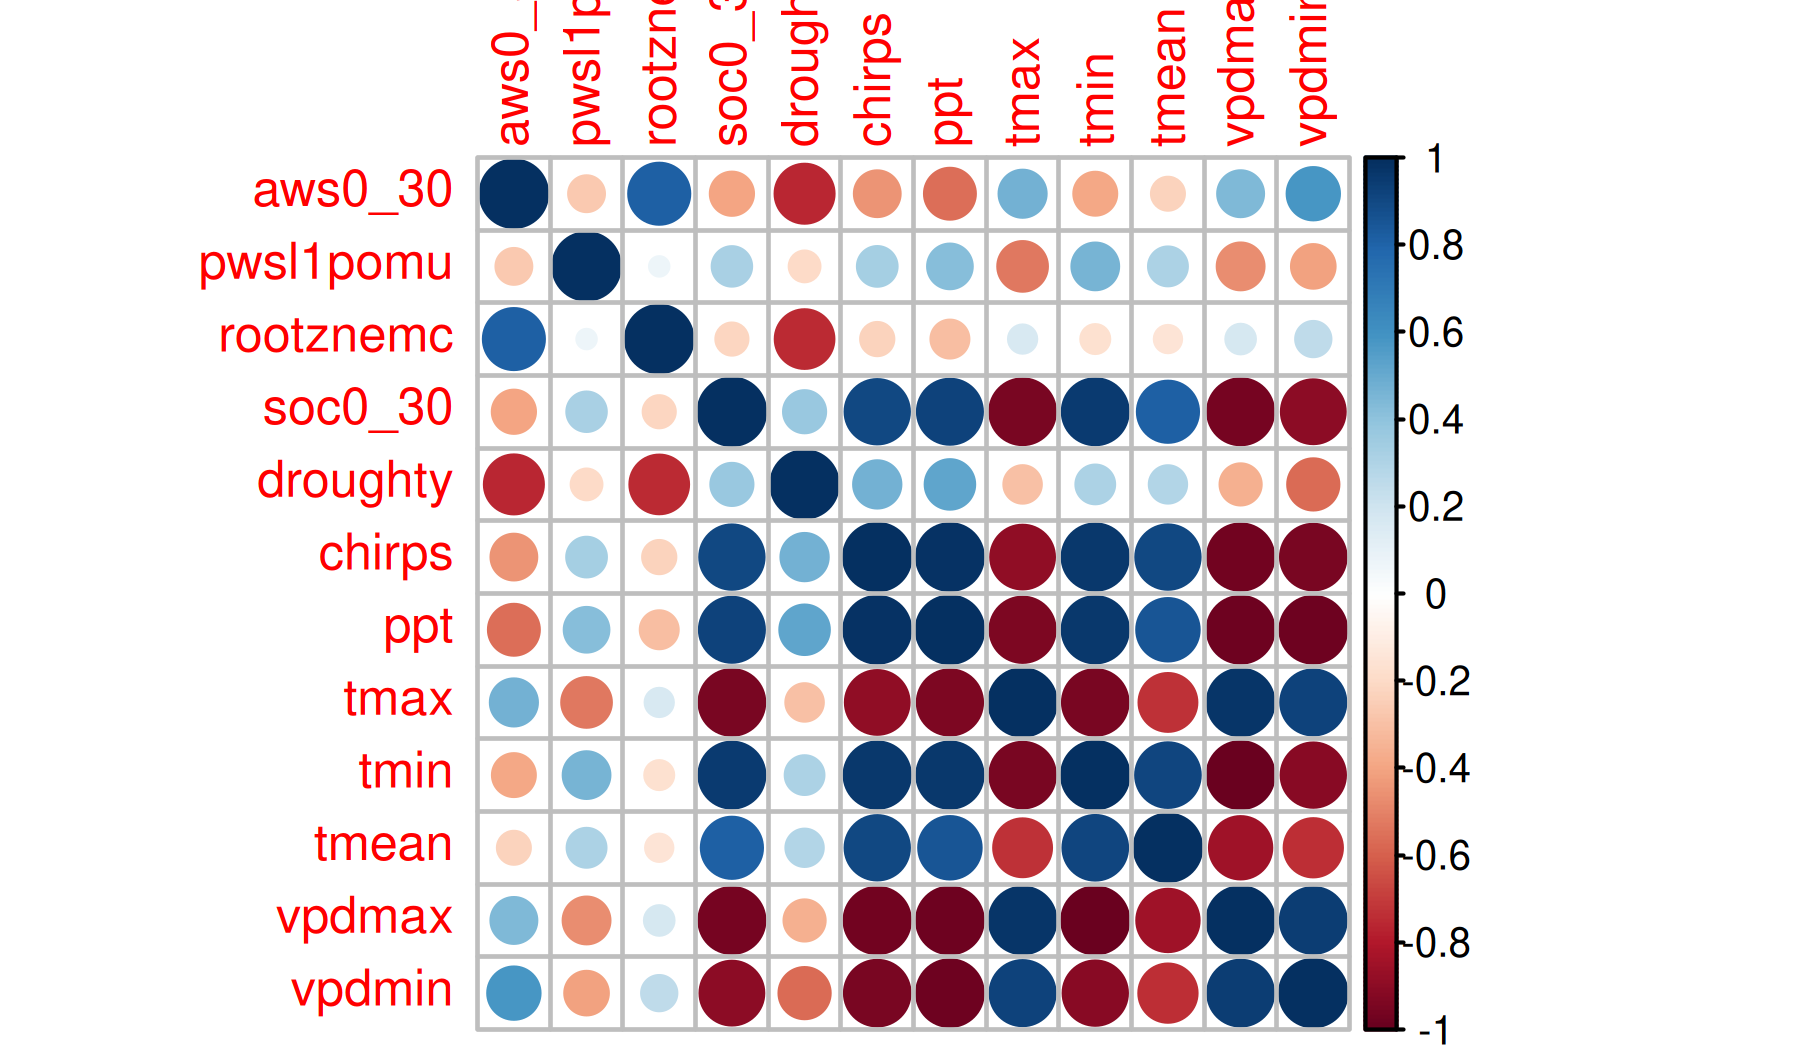

In [10]:
# ggcorplot(
#   cor(dataset[dataset$Species == "Rhizophagus irregularis", ])
# )
corrplot(cor(dataset[
  ,
  c(
    'aws0_30',
    'pwsl1pomu',
    'rootznemc',
    'soc0_30',
    'droughty',
    "chirps",
    'ppt',
    'tmax',
    'tmin',
    'tmean',
    'vpdmax',
    'vpdmin'
  )
], use = "complete.obs"), method = "circle", type = "full")

In [11]:
unique(dataset$Species)
count(st_drop_geometry(kansas_locations), Species) |> arrange(desc(n))

[1] "Rhizoglomus_sp"     "Glomeraceae_spp"    "Acaulospora_sp"    
 [4] "Septoglomus_sp"     "Glomus_sp"          "Claroideoglomus_sp"
 [7] "Archaeospora_sp"    "Diversispora_sp"    "Gigaspora_sp"      
[10] "Paraglomus_sp"      "Funneliformis_sp"   "Scutellospora_sp"  
[13] "Cetraspora_sp"      "Ambispora_sp"

Species            n  
1  Glomeraceae_spp    951
2  Rhizoglomus_sp     756
3  Claroideoglomus_sp 179
4  Septoglomus_sp     133
5  Glomus_sp          120
6  Diversispora_sp     66
7  Acaulospora_sp      61
8  Funneliformis_sp    31
9  Paraglomus_sp       30
10 Gigaspora_sp        20
11 Ambispora_sp        10
12 Scutellospora_sp    10
13 Archaeospora_sp      3
14 Cetraspora_sp        3

In [12]:
species_names <- c("Rhizoglomus_sp", "Claroideoglomus_sp", "Septoglomus_sp", "Glomus_sp")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.1351234  1.7206432  -1.241  0.21504    
aws0_30     -0.2520747  0.0509540  -4.947 9.30e-07 ***
rootznemc    0.1023825  0.0255911   4.001 6.94e-05 ***
soc0_30      0.0003558  0.0001850   1.923  0.05485 .  
chirps      -0.0049659  0.0017212  -2.885  0.00403 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 7.478509e-05)

    Null deviance: 0.057107  on 755  degrees of freedom
Residual deviance: 0.056148  on 751  degrees of freedom
AIC: -5030.5

Number of Fisher Scoring iterations: 10



Warning message:
“glm.fit: algorithm did not converge”


Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)    
aws0_30    11.7694  1  0.0006021 ***
rootznemc  12.0858  1  0.0005081 ***
soc0_30     4.5956  1  0.0320546 *  
chirps      6.8495  1  0.0088666 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


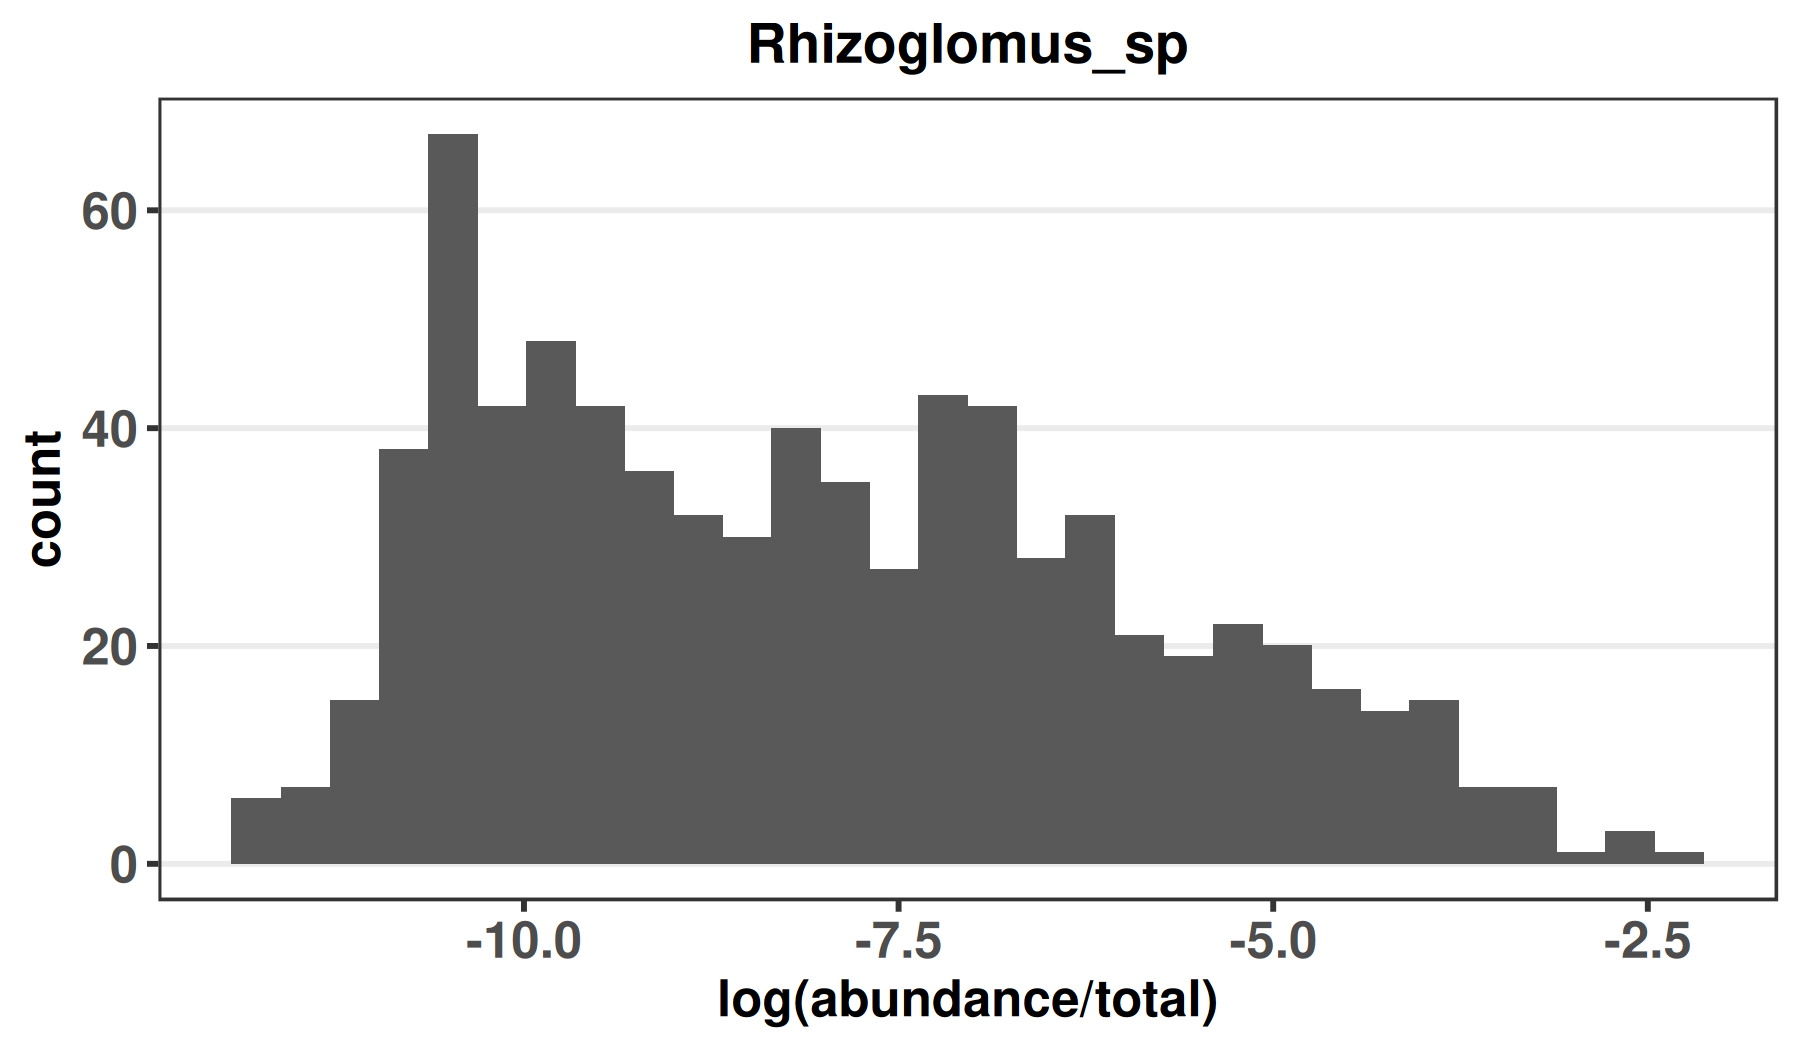

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


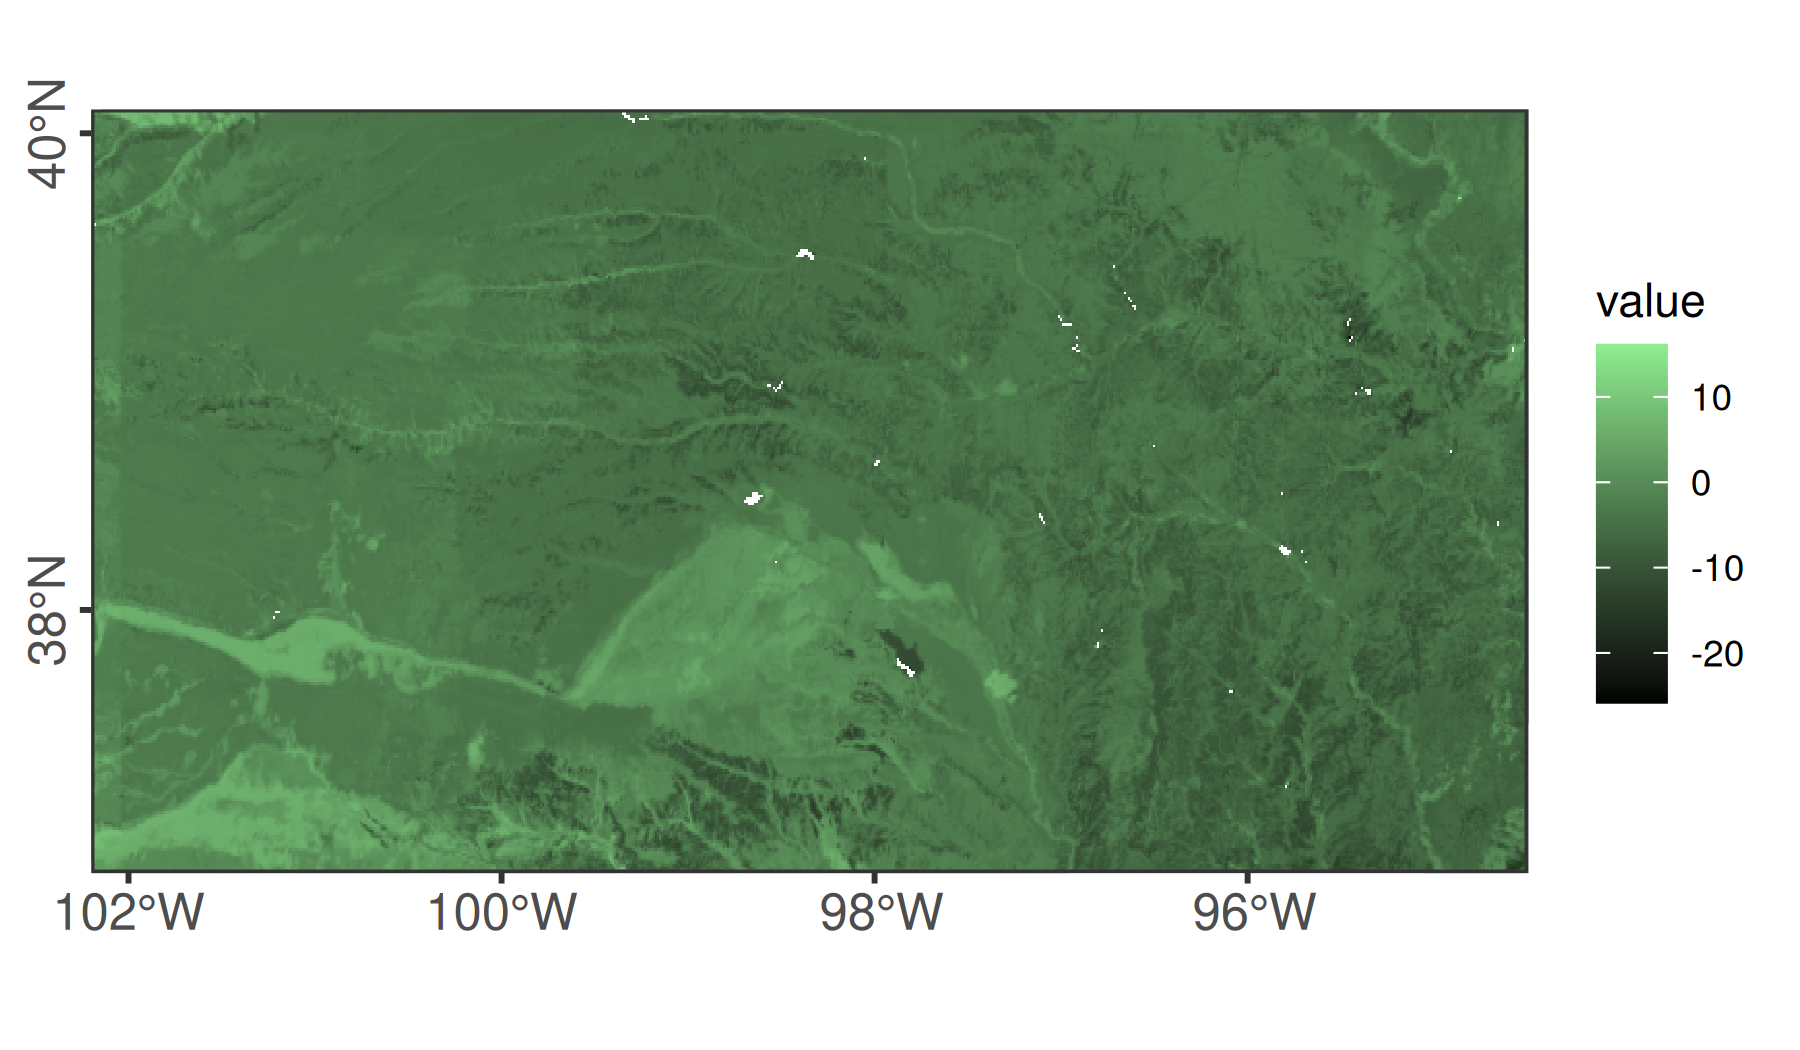


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -1.564e+02  9.471e+01  -1.651   0.1006  
aws0_30      3.151e+00  2.071e+00   1.522   0.1299  
rootznemc   -4.537e-01  3.234e-01  -1.403   0.1624  
soc0_30     -1.399e-02  8.387e-03  -1.668   0.0971 .
chirps       1.186e-01  6.909e-02   1.717   0.0877 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 3.668918e-05)

    Null deviance: 0.0069672  on 178  degrees of freedom
Residual deviance: 0.0063459  on 174  degrees of freedom
AIC: -1314.3

Number of Fisher Scoring iterations: 12

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)    
aws0_30     1.3183  1  0.2509025    
rootznemc   1.2848  1  0.2569992    
soc0_30     1.3495

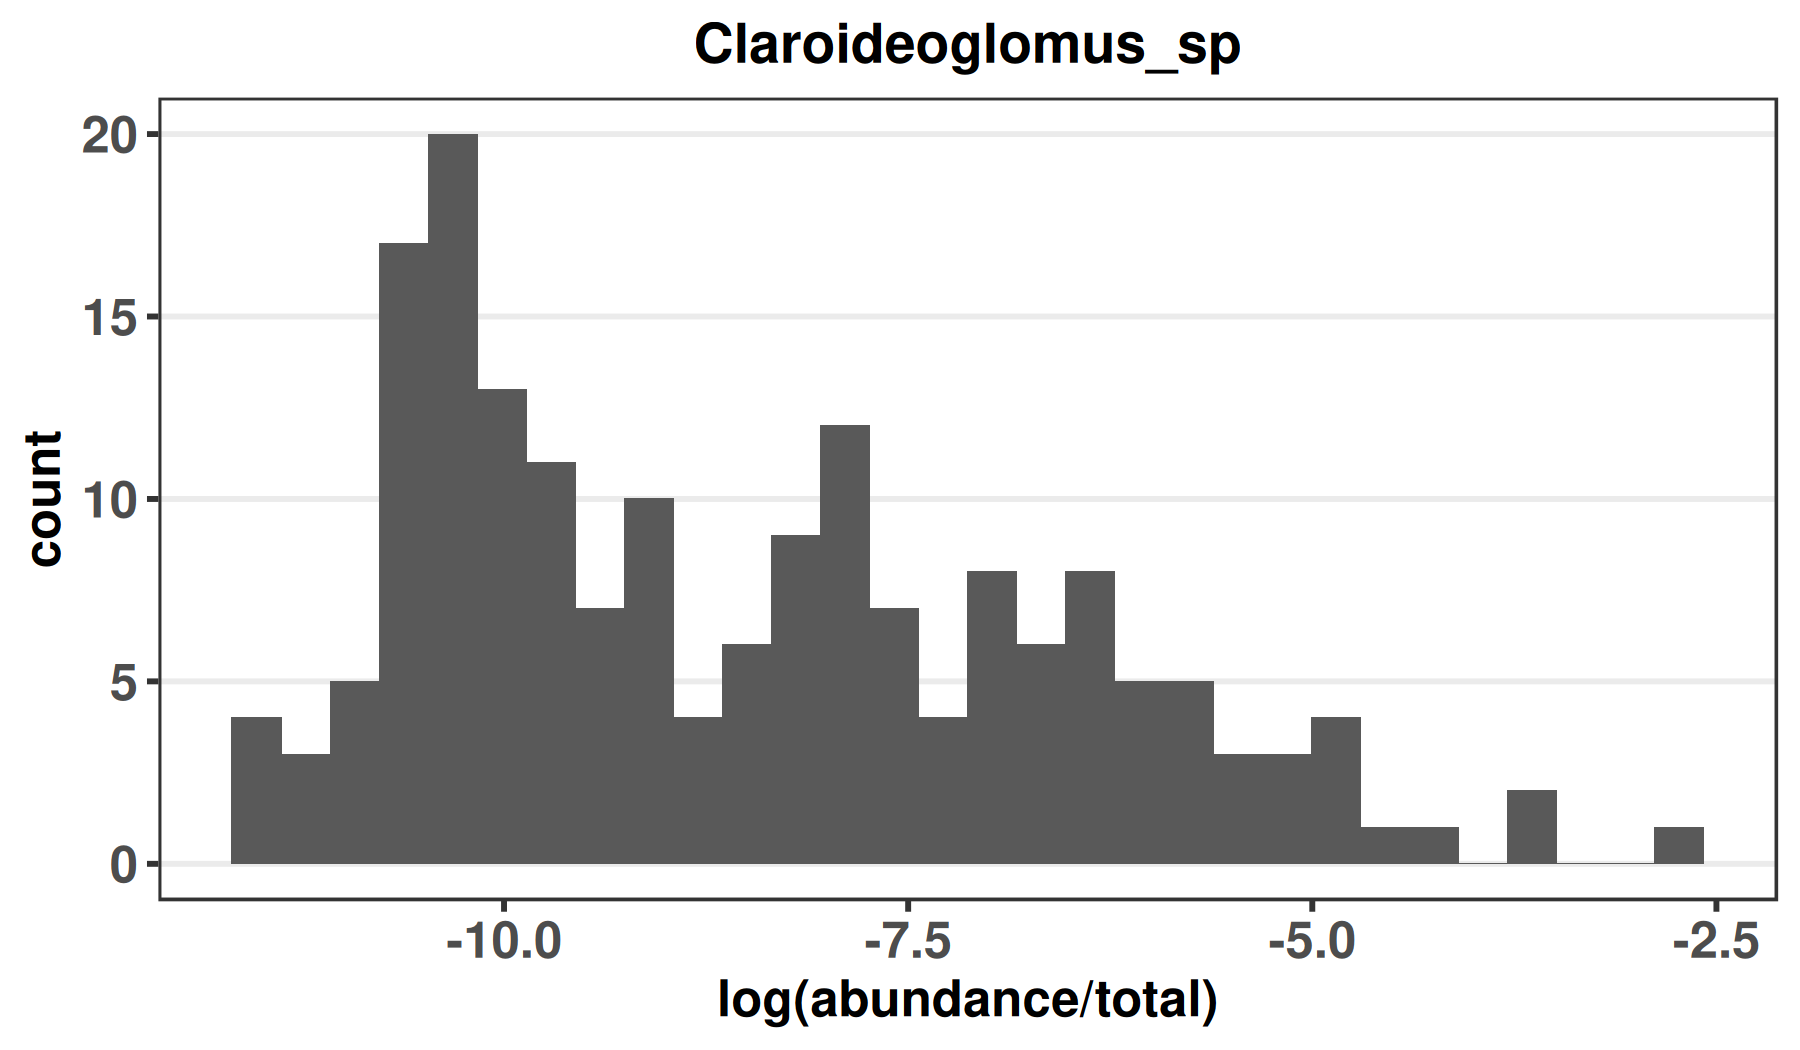

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


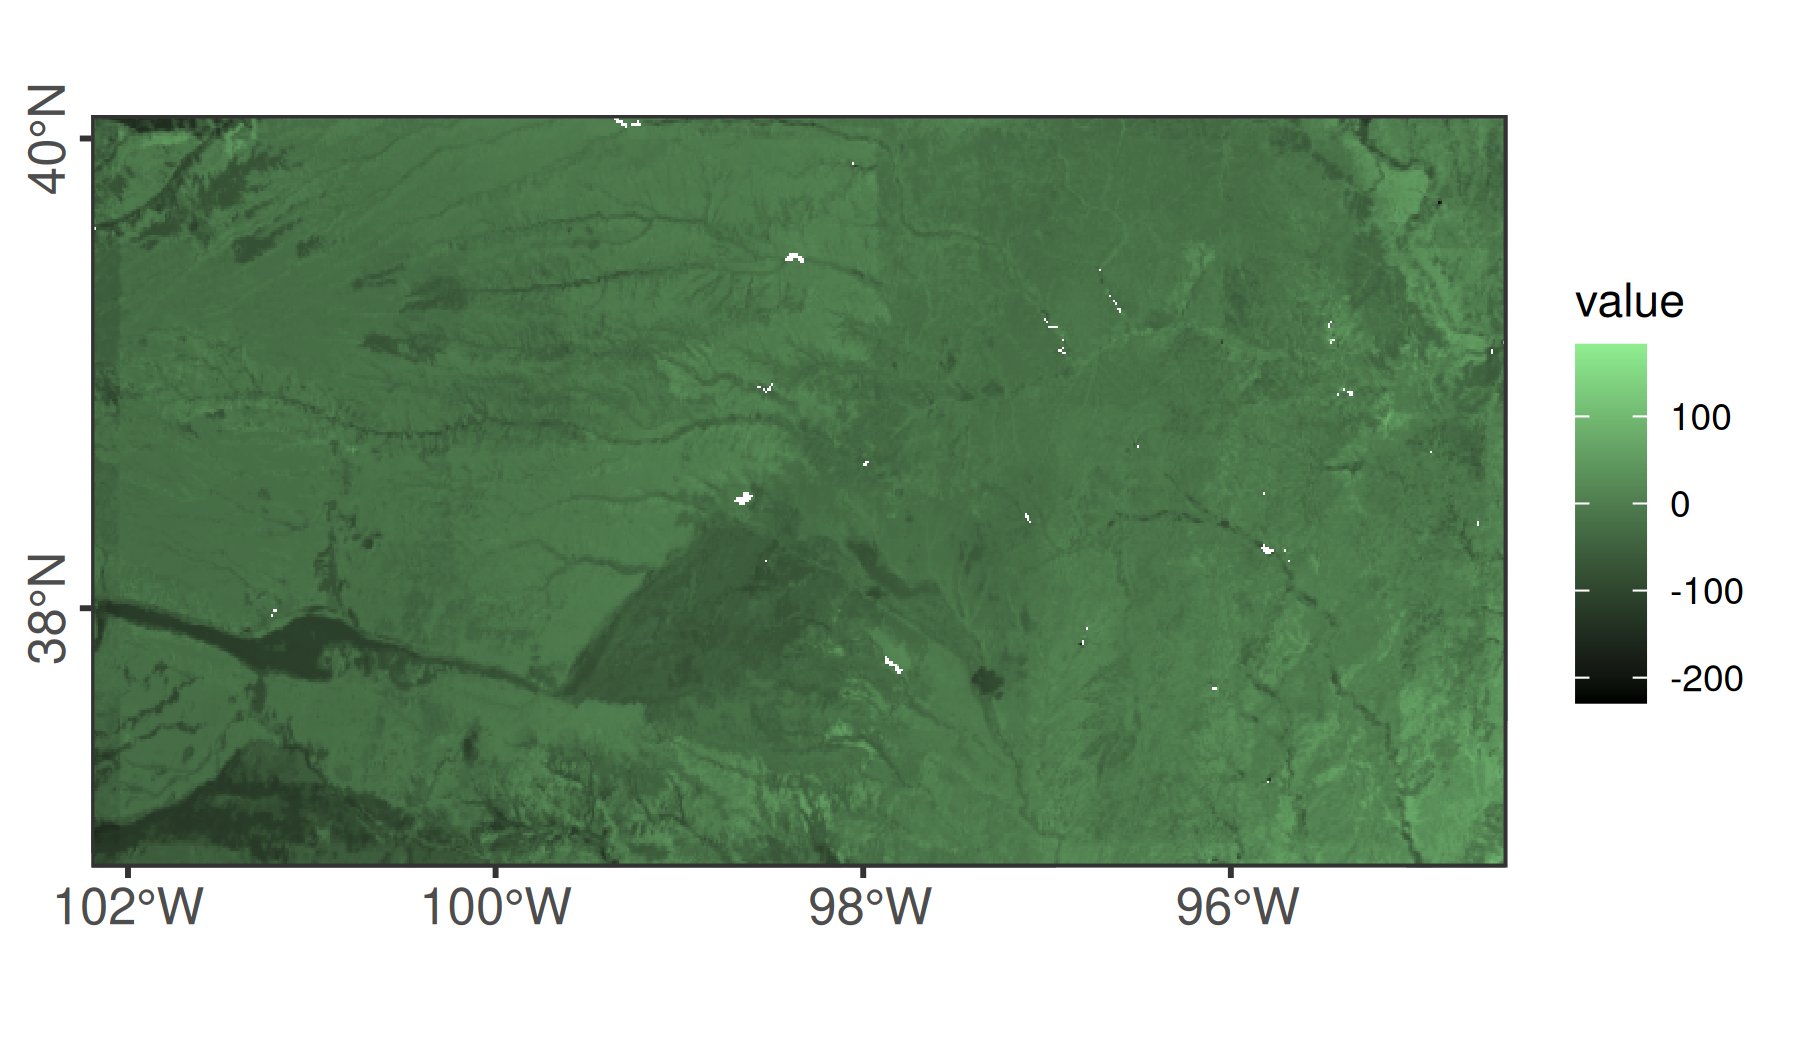


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -6.9231509  4.4384550  -1.560    0.121
aws0_30      0.0008249  0.0828096   0.010    0.992
rootznemc   -0.0055753  0.0214918  -0.259    0.796
soc0_30      0.0004461  0.0003106   1.436    0.153
chirps      -0.0017219  0.0034349  -0.501    0.617

(Dispersion parameter for gaussian family taken to be 1.636863e-05)

    Null deviance: 0.0021446  on 132  degrees of freedom
Residual deviance: 0.0020952  on 128  degrees of freedom
AIC: -1081.3

Number of Fisher Scoring iterations: 10

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)
aws0_30    0.00013  1     0.9910
rootznemc  0.08053  1     0.7766
soc0_30    2.06235  1     0.1510
chirps     0.23136  1     0.6305


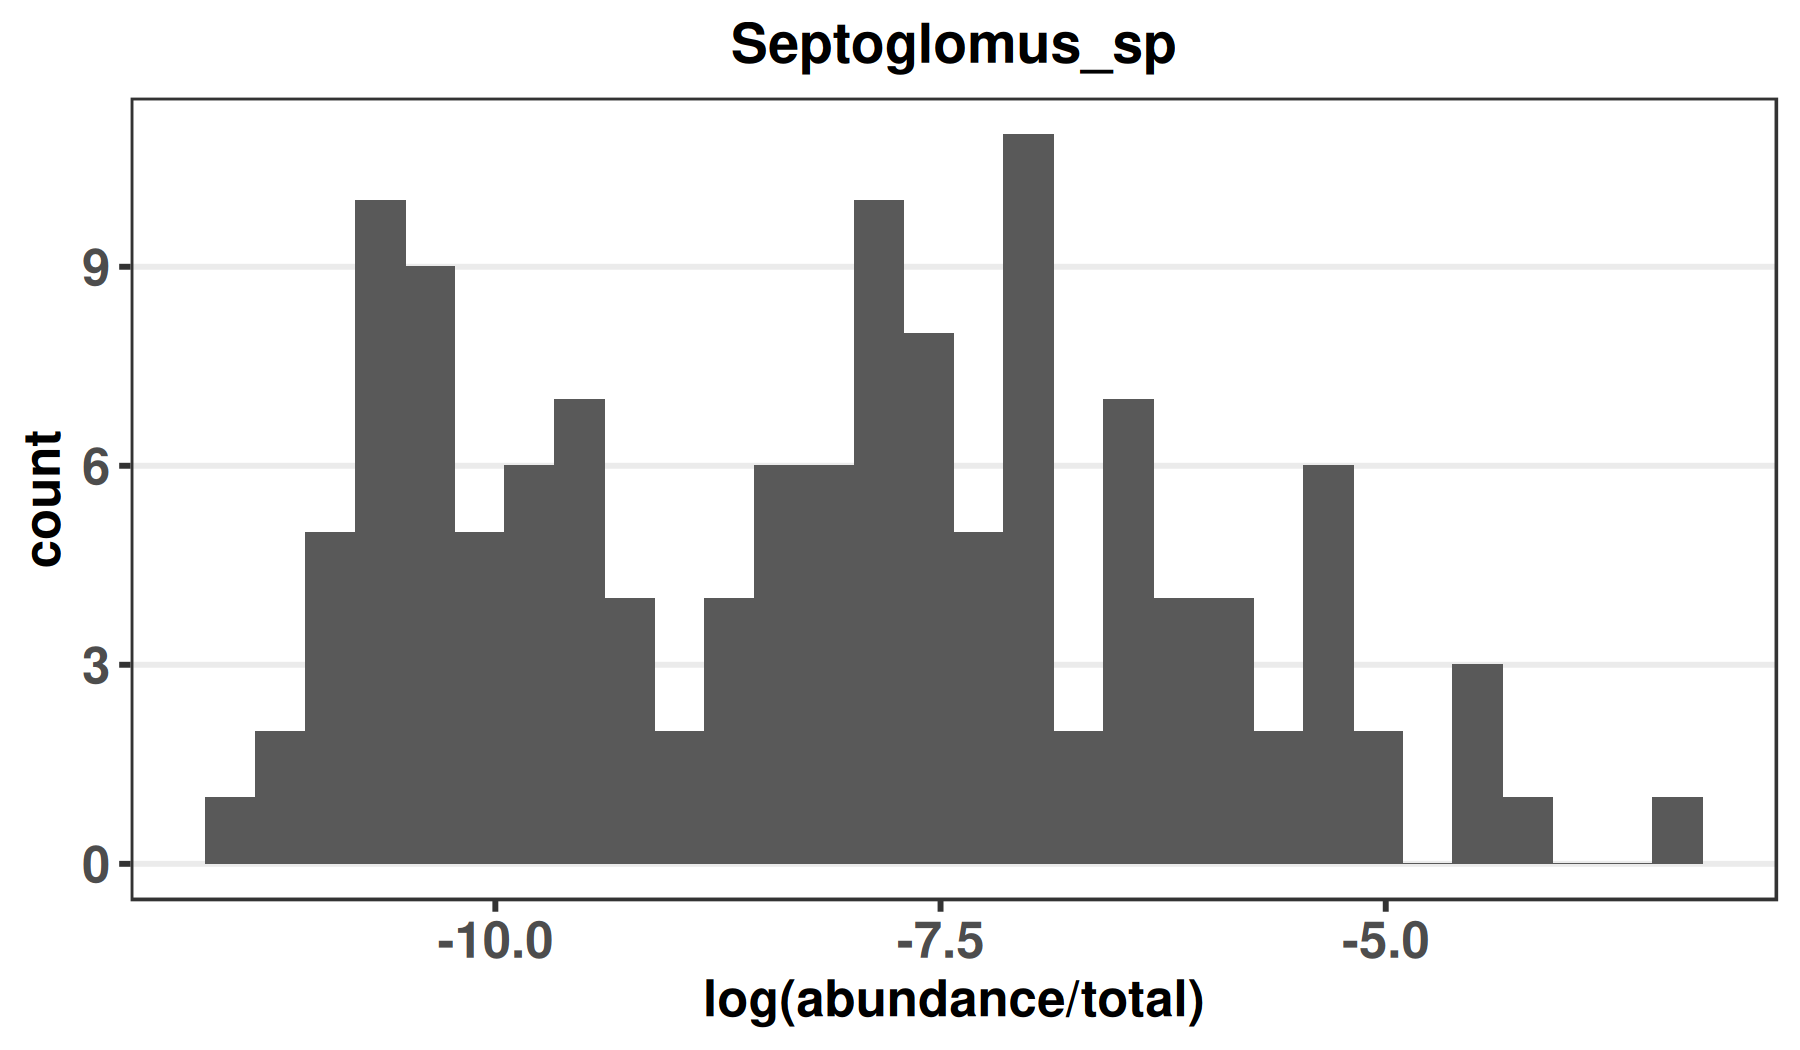

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


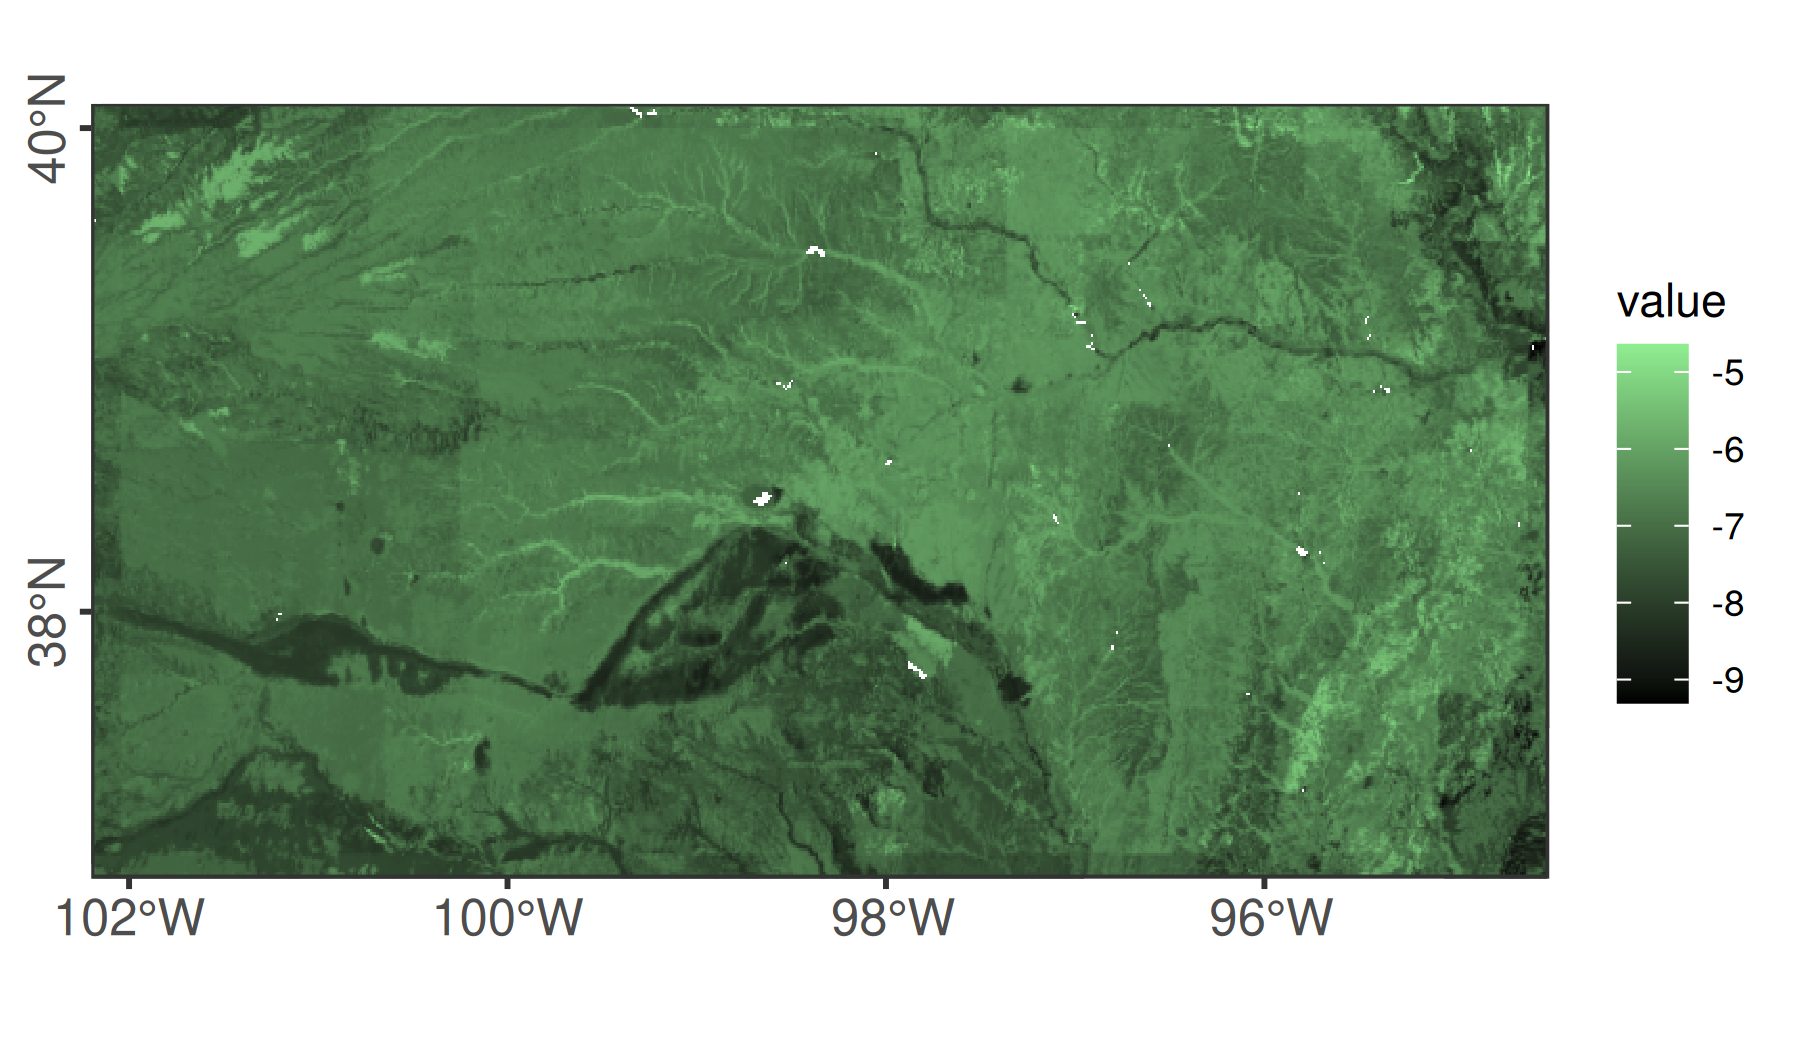


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) 10.8966923 10.6921333   1.019    0.310
aws0_30     -0.2635385  0.1879048  -1.403    0.163
rootznemc    0.0093131  0.0272501   0.342    0.733
soc0_30     -0.0007612  0.0005176  -1.471    0.144
chirps      -0.0015304  0.0031992  -0.478    0.633

(Dispersion parameter for gaussian family taken to be 6.665653e-06)

    Null deviance: 0.00087796  on 119  degrees of freedom
Residual deviance: 0.00076578  on 115  degrees of freedom
AIC: -1082.9

Number of Fisher Scoring iterations: 8

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)  
aws0_30     5.1890  1    0.02273 *
rootznemc   0.1964  1    0.65762  
soc0_30     3.7169  1    0.05386 .
chirps      0.2667  1    0.60558  
---
Signif. codes:  0 ‘***’ 0.00

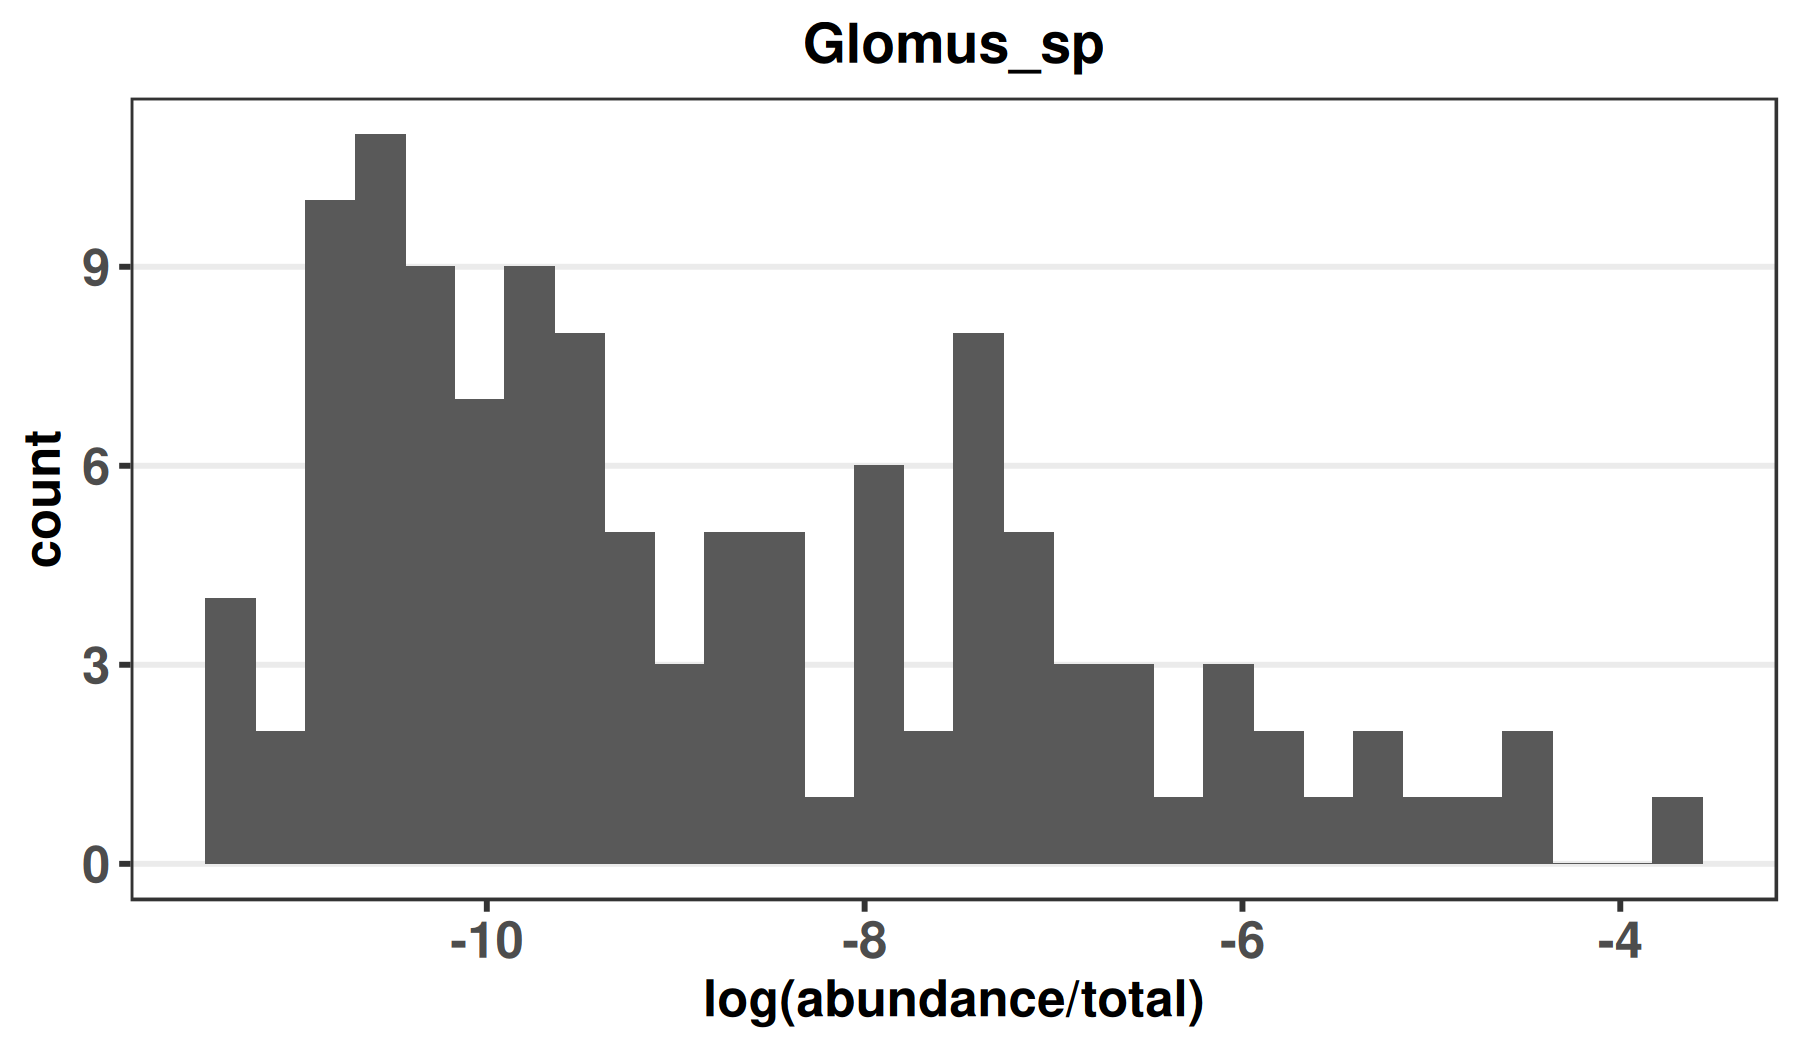

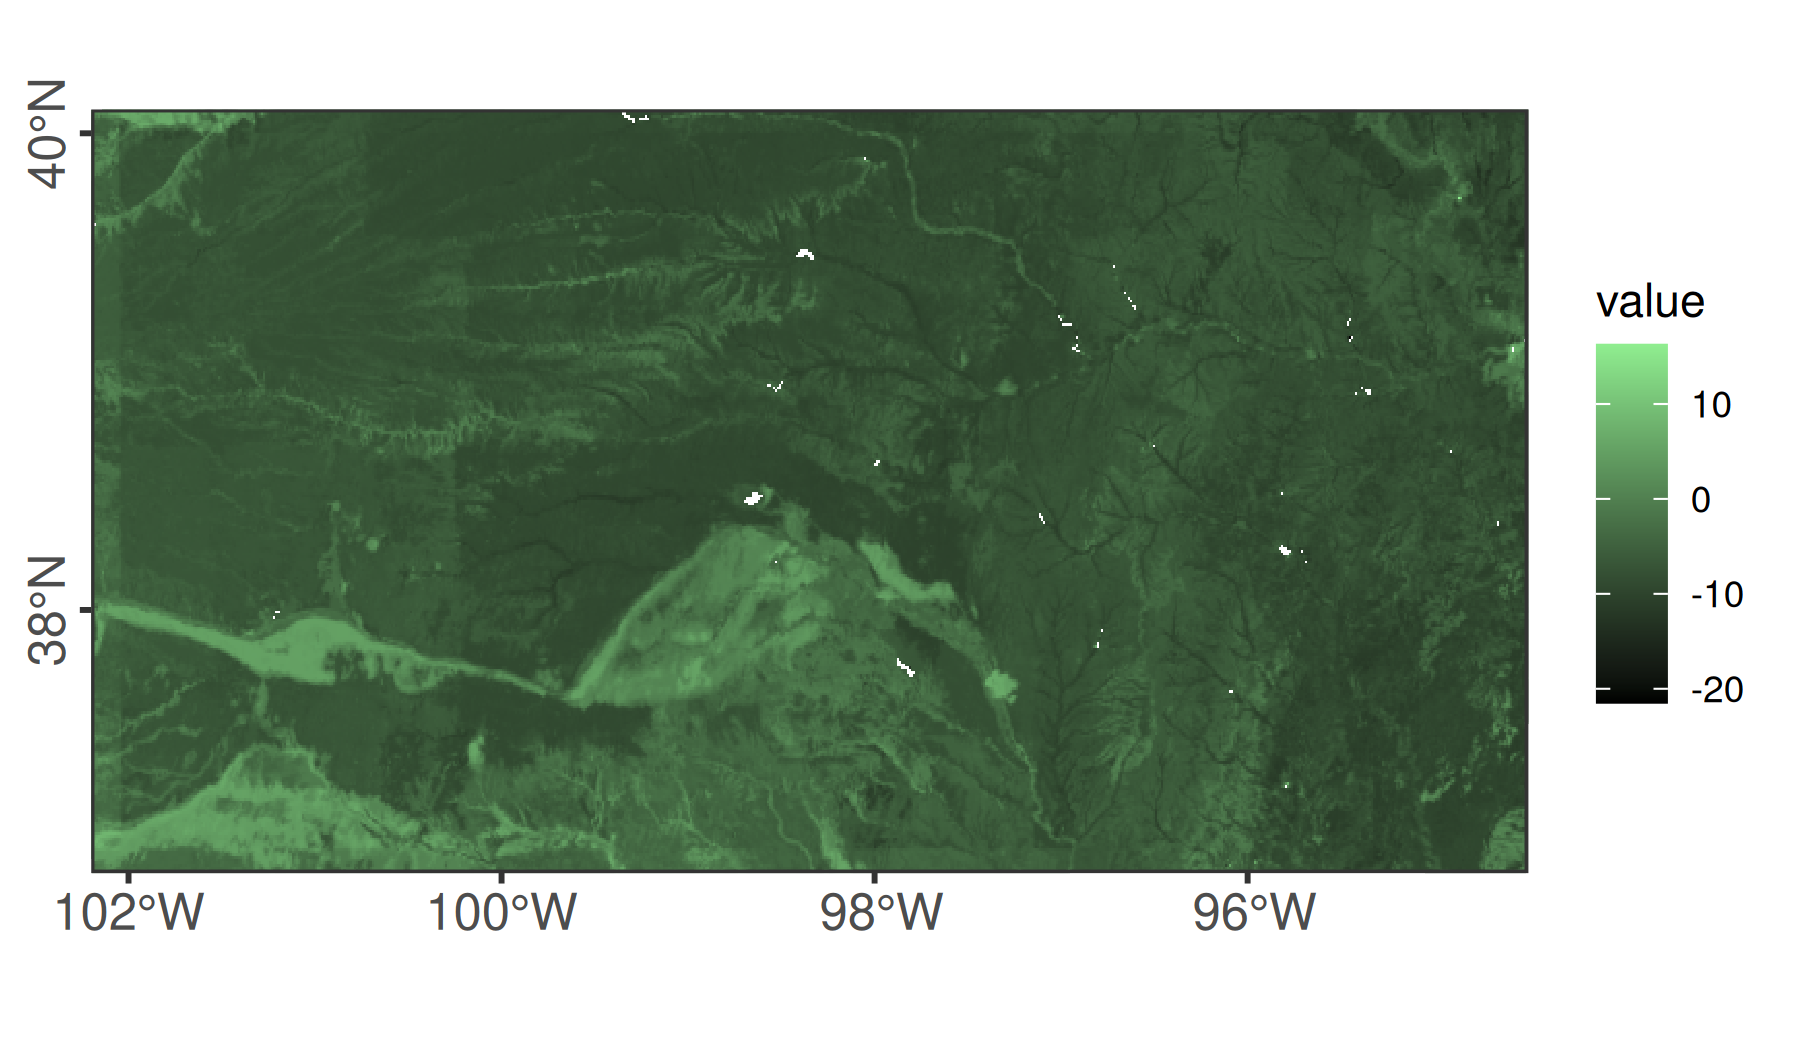

In [18]:
for(species in species_names) {
  histogram_plot <- ggplot(data = dataset[dataset$Species == species, ]) +
    geom_histogram(aes(x = log(abundance/total))) +
    labs(title = species)
  print(histogram_plot)

  model <- glm(
    proportion ~
      aws0_30 +
      # pwsl1pomu +
      rootznemc +
      soc0_30 +
      # droughty +
      # tmax +
      # tmin +
      # tmean +
      # vpdmax +
      # vpdmin +
      chirps
    ,
    family = gaussian(link = "log"),
    data = dataset[dataset$Species == species, ]
  )
  print(summary(model))
  print(Anova(model, type = 2))

  output <- predict(kansas_gis_dataset, model)
  niche_model_map <- ggplot() +
    geom_spatraster(data = output, aes(fill = lyr1)) +
    labs(x = NULL, y = NULL) +
    coord_sf(
      crs = "WGS84", default_crs = "WGS84",
      xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
    ) +
    scale_x_continuous(breaks = seq(-180, 180, 2)) +
    scale_y_continuous(breaks = seq(-90, 90, 2)) +
    scale_fill_gradient(
      low = "black",
      high = "lightgreen",
      na.value = "white"
    ) +
    theme(
      legend.position = "right",
      legend.direction = "vertical",
      axis.text.y = element_text(angle = 90, hjust = 0.5)
    )
  print(niche_model_map)
}

In [19]:
dbDisconnect(con, shutdown = TRUE)